# Modeling - Wizeline ML Challenge

Complete pipeline: training, comparison, selection, and deployment.

**Strategy:**
- Hold-out 80/20 (640 train / 160 test)
- 5-fold cross-validation on train to compare models and tune hyperparameters
- Final evaluation of the winner on the test hold-out
- Retrain with all 800 samples to predict the blind test
- Save model as .pkl for future predictions
- Experiment tracking with MLflow

**Models:**
1. Linear Regression (baseline)
2. Ridge / Lasso (regularization)
3. Random Forest
4. XGBoost
5. SVR (RBF kernel)

Each model is tested with and without interactions.
Scale-sensitive models (Ridge, Lasso, SVR) are standardized.


## 0. Imports and configuration


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import time
import joblib
import os

from sklearn.model_selection import (
    train_test_split, cross_val_score,
    GridSearchCV, RandomizedSearchCV, KFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
    print("XGBoost available")
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed. Install with: pip install xgboost")

try:
    import mlflow
    import mlflow.sklearn
    HAS_MLFLOW = True
    print("MLflow available")
except ImportError:
    HAS_MLFLOW = False
    print("MLflow not installed. Install with: pip install mlflow")

np.random.seed(42)

os.makedirs('models', exist_ok=True)
os.makedirs('predictions', exist_ok=True)

print("\nImports and directories OK")


XGBoost available
MLflow available

Imports and directories OK


In [4]:
!pip install mlflow

## 1. Data loading


In [5]:
df = pd.read_csv('training_data.csv')
features = [c for c in df.columns if c != 'target']
X = df[features].copy()
y = df['target'].copy()

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")


Dataset: 800 samples, 20 features


## 2. Interaction features


In [6]:
top_interact = ['feature_2', 'feature_13', 'feature_9', 'feature_11']

def add_interactions(df_input, feature_pairs):
    """Add interaction columns (products) to the dataframe."""
    df_out = df_input.copy()
    interaction_cols = []
    for i in range(len(feature_pairs)):
        for j in range(i+1, len(feature_pairs)):
            f1, f2 = feature_pairs[i], feature_pairs[j]
            col_name = f'{f1}_x_{f2}'
            df_out[col_name] = df_out[f1] * df_out[f2]
            interaction_cols.append(col_name)
    return df_out, interaction_cols

X_interact, interaction_cols = add_interactions(X, top_interact)

print(f"Original features: {len(features)}")
print(f"Interactions created: {len(interaction_cols)}")
print(f"Total features with interactions: {X_interact.shape[1]}")
print(f"\nInteractions: {interaction_cols}")


Original features: 20
Interactions created: 6
Total features with interactions: 26

Interactions: ['feature_2_x_feature_13', 'feature_2_x_feature_9', 'feature_2_x_feature_11', 'feature_13_x_feature_9', 'feature_13_x_feature_11', 'feature_9_x_feature_11']


## 3. Train/test split (80/20)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_int, X_test_int, _, _ = train_test_split(
    X_interact, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")


Train: 640 samples
Test:  160 samples


## 4. Model definitions and CV configuration


In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X_tr, y_tr, X_te, y_te, model_name):
    """Evaluate model with CV on train and metrics on test."""
    start = time.time()

    cv_r2 = cross_val_score(model, X_tr, y_tr, cv=cv, scoring='r2')
    cv_rmse = -cross_val_score(model, X_tr, y_tr, cv=cv, scoring='neg_root_mean_squared_error')
    cv_mae = -cross_val_score(model, X_tr, y_tr, cv=cv, scoring='neg_mean_absolute_error')

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    test_r2 = r2_score(y_te, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    test_mae = mean_absolute_error(y_te, y_pred)

    elapsed = time.time() - start

    result = {
        'Model': model_name,
        'CV_R2_mean': cv_r2.mean(),
        'CV_R2_std': cv_r2.std(),
        'CV_RMSE_mean': cv_rmse.mean(),
        'CV_RMSE_std': cv_rmse.std(),
        'CV_MAE_mean': cv_mae.mean(),
        'CV_MAE_std': cv_mae.std(),
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Time_s': elapsed
    }

    print(f"  {model_name:<40} | CV R2: {cv_r2.mean():.4f} +/- {cv_r2.std():.4f} | Test R2: {test_r2:.4f} | RMSE: {test_rmse:.4f} | {elapsed:.1f}s")
    return result, model

print("Evaluation function defined")


Evaluation function defined


## 5. First round - default parameters


In [9]:
results = []
trained_models = {}

print("=" * 110)
print("MODELS WITHOUT INTERACTIONS")
print("=" * 110)

print("\nLinear Regression:")
r, m = evaluate_model(LinearRegression(), X_train, y_train, X_test, y_test, "Linear Regression")
results.append(r); trained_models[r['Model']] = m

print("\nRidge:")
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))])
r, m = evaluate_model(pipe_ridge, X_train, y_train, X_test, y_test, "Ridge")
results.append(r); trained_models[r['Model']] = m

print("\nLasso:")
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=1.0, max_iter=10000))])
r, m = evaluate_model(pipe_lasso, X_train, y_train, X_test, y_test, "Lasso")
results.append(r); trained_models[r['Model']] = m

print("\nRandom Forest:")
r, m = evaluate_model(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
                       X_train, y_train, X_test, y_test, "Random Forest")
results.append(r); trained_models[r['Model']] = m

if HAS_XGB:
    print("\nXGBoost:")
    r, m = evaluate_model(XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
                           X_train, y_train, X_test, y_test, "XGBoost")
    results.append(r); trained_models[r['Model']] = m

print("\nSVR (RBF):")
pipe_svr = Pipeline([('scaler', StandardScaler()), ('model', SVR(kernel='rbf'))])
r, m = evaluate_model(pipe_svr, X_train, y_train, X_test, y_test, "SVR (RBF)")
results.append(r); trained_models[r['Model']] = m


MODELS WITHOUT INTERACTIONS

Linear Regression:
  Linear Regression                        | CV R2: 0.6785 +/- 0.0391 | Test R2: 0.6962 | RMSE: 2.6118 | 0.1s

Ridge:
  Ridge                                    | CV R2: 0.6786 +/- 0.0389 | Test R2: 0.6961 | RMSE: 2.6122 | 0.2s

Lasso:
  Lasso                                    | CV R2: 0.5439 +/- 0.0191 | Test R2: 0.5193 | RMSE: 3.2852 | 0.1s

Random Forest:
  Random Forest                            | CV R2: 0.7383 +/- 0.0166 | Test R2: 0.7219 | RMSE: 2.4986 | 42.8s

XGBoost:
  XGBoost                                  | CV R2: 0.7518 +/- 0.0260 | Test R2: 0.7717 | RMSE: 2.2638 | 15.1s

SVR (RBF):
  SVR (RBF)                                | CV R2: 0.6311 +/- 0.0102 | Test R2: 0.6556 | RMSE: 2.7807 | 0.9s


In [10]:
print("\n" + "=" * 110)
print("MODELS WITH INTERACTIONS")
print("=" * 110)

print("\nLinear Regression + Interactions:")
r, m = evaluate_model(LinearRegression(), X_train_int, y_train, X_test_int, y_test, "Linear Regression + Interact")
results.append(r); trained_models[r['Model']] = m

print("\nRidge + Interactions:")
pipe_ridge_int = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=1.0))])
r, m = evaluate_model(pipe_ridge_int, X_train_int, y_train, X_test_int, y_test, "Ridge + Interact")
results.append(r); trained_models[r['Model']] = m

print("\nLasso + Interactions:")
pipe_lasso_int = Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=1.0, max_iter=10000))])
r, m = evaluate_model(pipe_lasso_int, X_train_int, y_train, X_test_int, y_test, "Lasso + Interact")
results.append(r); trained_models[r['Model']] = m

print("\nRandom Forest + Interactions:")
r, m = evaluate_model(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
                       X_train_int, y_train, X_test_int, y_test, "Random Forest + Interact")
results.append(r); trained_models[r['Model']] = m

if HAS_XGB:
    print("\nXGBoost + Interactions:")
    r, m = evaluate_model(XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
                           X_train_int, y_train, X_test_int, y_test, "XGBoost + Interact")
    results.append(r); trained_models[r['Model']] = m

print("\nSVR (RBF) + Interactions:")
pipe_svr_int = Pipeline([('scaler', StandardScaler()), ('model', SVR(kernel='rbf'))])
r, m = evaluate_model(pipe_svr_int, X_train_int, y_train, X_test_int, y_test, "SVR (RBF) + Interact")
results.append(r); trained_models[r['Model']] = m



MODELS WITH INTERACTIONS

Linear Regression + Interactions:
  Linear Regression + Interact             | CV R2: 0.6747 +/- 0.0322 | Test R2: 0.6916 | RMSE: 2.6315 | 0.1s

Ridge + Interactions:
  Ridge + Interact                         | CV R2: 0.6747 +/- 0.0321 | Test R2: 0.6920 | RMSE: 2.6295 | 0.2s

Lasso + Interactions:
  Lasso + Interact                         | CV R2: 0.5714 +/- 0.0151 | Test R2: 0.5737 | RMSE: 3.0936 | 0.2s

Random Forest + Interactions:
  Random Forest + Interact                 | CV R2: 0.8037 +/- 0.0164 | Test R2: 0.8146 | RMSE: 2.0405 | 44.7s

XGBoost + Interactions:
  XGBoost + Interact                       | CV R2: 0.8030 +/- 0.0284 | Test R2: 0.8123 | RMSE: 2.0529 | 19.1s

SVR (RBF) + Interactions:
  SVR (RBF) + Interact                     | CV R2: 0.7069 +/- 0.0106 | Test R2: 0.7162 | RMSE: 2.5242 | 0.5s


## 6. Comparative results table (first round)



RANKING BY CV R2 (higher is better):

                       Model  CV_R2_mean  CV_R2_std  CV_RMSE_mean  Test_R2  Test_RMSE  Test_MAE    Time_s
    Random Forest + Interact    0.803671   0.016417      2.277719 0.814551   2.040481  1.673984 44.726963
          XGBoost + Interact    0.802984   0.028415      2.275503 0.812292   2.052874  1.603529 19.100673
                     XGBoost    0.751783   0.026008      2.563629 0.771747   2.263754  1.788250 15.127390
               Random Forest    0.738288   0.016595      2.632701 0.721933   2.498592  1.999858 42.796092
        SVR (RBF) + Interact    0.706876   0.010580      2.789109 0.716209   2.524179  2.080706  0.540294
                       Ridge    0.678557   0.038933      2.913169 0.696076   2.612181  2.109524  0.162107
           Linear Regression    0.678480   0.039084      2.913444 0.696167   2.611788  2.108786  0.126327
            Ridge + Interact    0.674685   0.032111      2.933247 0.692028   2.629518  2.096999  0.175564
Linear 

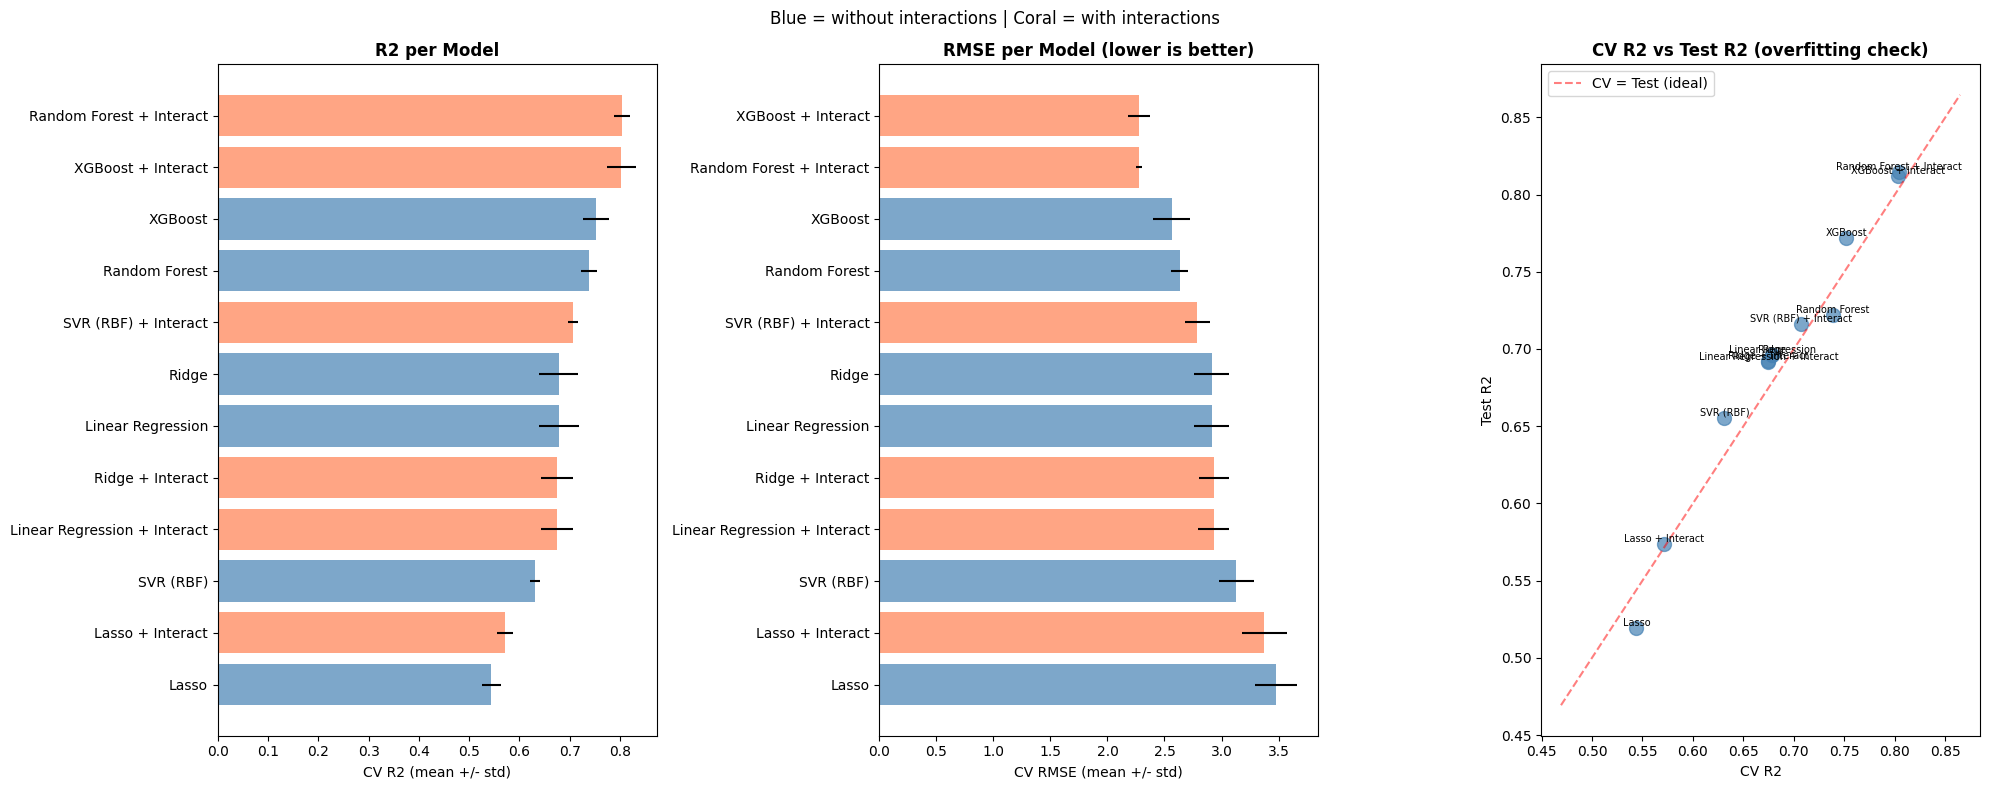

In [11]:
results_df = pd.DataFrame(results).sort_values('CV_R2_mean', ascending=False)

print("\nRANKING BY CV R2 (higher is better):\n")
display_cols = ['Model', 'CV_R2_mean', 'CV_R2_std', 'CV_RMSE_mean', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Time_s']
print(results_df[display_cols].to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

results_sorted = results_df.sort_values('CV_R2_mean', ascending=True)
colors = ['coral' if 'Interact' in m else 'steelblue' for m in results_sorted['Model']]
axes[0].barh(results_sorted['Model'], results_sorted['CV_R2_mean'],
             xerr=results_sorted['CV_R2_std'], color=colors, alpha=0.7)
axes[0].set_xlabel('CV R2 (mean +/- std)')
axes[0].set_title('R2 per Model', fontweight='bold')

results_sorted_rmse = results_df.sort_values('CV_RMSE_mean', ascending=False)
colors_rmse = ['coral' if 'Interact' in m else 'steelblue' for m in results_sorted_rmse['Model']]
axes[1].barh(results_sorted_rmse['Model'], results_sorted_rmse['CV_RMSE_mean'],
             xerr=results_sorted_rmse['CV_RMSE_std'], color=colors_rmse, alpha=0.7)
axes[1].set_xlabel('CV RMSE (mean +/- std)')
axes[1].set_title('RMSE per Model (lower is better)', fontweight='bold')

axes[2].scatter(results_df['CV_R2_mean'], results_df['Test_R2'], s=100, c='steelblue', alpha=0.7)
for _, row in results_df.iterrows():
    axes[2].annotate(row['Model'], (row['CV_R2_mean'], row['Test_R2']), fontsize=7, ha='center', va='bottom')
min_val = min(results_df['CV_R2_mean'].min(), results_df['Test_R2'].min()) - 0.05
max_val = max(results_df['CV_R2_mean'].max(), results_df['Test_R2'].max()) + 0.05
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='CV = Test (ideal)')
axes[2].set_xlabel('CV R2')
axes[2].set_ylabel('Test R2')
axes[2].set_title('CV R2 vs Test R2 (overfitting check)', fontweight='bold')
axes[2].legend()

plt.suptitle('Blue = without interactions | Coral = with interactions', fontsize=12)
plt.tight_layout()
plt.show()


## 7. Top 3 model selection for tuning


In [12]:
top3 = results_df.head(3)['Model'].tolist()
print("Top 3 models for tuning:")
for i, m in enumerate(top3):
    r2 = results_df[results_df['Model'] == m]['CV_R2_mean'].values[0]
    print(f"  {i+1}. {m} (CV R2 = {r2:.4f})")

uses_interactions = {m: 'Interact' in m for m in top3}
print(f"\nUse interactions: {uses_interactions}")


Top 3 models for tuning:
  1. Random Forest + Interact (CV R2 = 0.8037)
  2. XGBoost + Interact (CV R2 = 0.8030)
  3. XGBoost (CV R2 = 0.7518)

Use interactions: {'Random Forest + Interact': True, 'XGBoost + Interact': True, 'XGBoost': False}


## 8. Hyperparameter Tuning

**RandomizedSearchCV** (50 iterations) for Random Forest and XGBoost.
**GridSearchCV** for fast models (Ridge, Lasso, SVR).


In [13]:
tuning_results = []
tuned_models = {}

def run_tuning(model, param_dist, X_tr, y_tr, X_te, y_te, model_name, use_random=False, n_iter=50):
    """Run GridSearchCV or RandomizedSearchCV and evaluate on test."""
    print(f"\nTuning {model_name}...")

    if use_random:
        print(f"   RandomizedSearchCV: {n_iter} iterations x 5 folds = {n_iter * 5} fits")
        searcher = RandomizedSearchCV(
            model, param_dist, n_iter=n_iter, cv=cv, scoring='r2',
            n_jobs=-1, verbose=0, random_state=42, return_train_score=True
        )
    else:
        total = np.prod([len(v) for v in param_dist.values()])
        print(f"   GridSearchCV: {total} combinations x 5 folds = {total * 5} fits")
        searcher = GridSearchCV(
            model, param_dist, cv=cv, scoring='r2',
            n_jobs=-1, verbose=0, return_train_score=True
        )

    start = time.time()
    searcher.fit(X_tr, y_tr)
    elapsed = time.time() - start

    y_pred = searcher.predict(X_te)
    test_r2 = r2_score(y_te, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    test_mae = mean_absolute_error(y_te, y_pred)

    print(f"   Best CV R2: {searcher.best_score_:.4f}")
    print(f"   Test R2: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f}")
    print(f"   Best params: {searcher.best_params_}")
    print(f"   Time: {elapsed:.1f}s")

    result = {
        'Model': model_name,
        'Best_CV_R2': searcher.best_score_,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Best_Params': searcher.best_params_,
        'Time_s': elapsed
    }

    return result, searcher.best_estimator_

print("Tuning function defined")


Tuning function defined


In [14]:
print("=" * 80)
print("HYPERPARAMETER TUNING - TOP 3 MODELS")
print("=" * 80)

rf_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

xgb_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

ridge_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}

lasso_grid = {
    'model__alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
}

svr_grid = {
    'model__C': [0.1, 1, 10, 50, 100],
    'model__epsilon': [0.01, 0.05, 0.1, 0.5],
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

model_configs = {
    'Linear Regression': {
        'model': LinearRegression(), 'grid': {},
        'uses_interact': False, 'use_random': False
    },
    'Linear Regression + Interact': {
        'model': LinearRegression(), 'grid': {},
        'uses_interact': True, 'use_random': False
    },
    'Ridge': {
        'model': Pipeline([('scaler', StandardScaler()), ('model', Ridge(max_iter=10000))]),
        'grid': ridge_grid, 'uses_interact': False, 'use_random': False
    },
    'Ridge + Interact': {
        'model': Pipeline([('scaler', StandardScaler()), ('model', Ridge(max_iter=10000))]),
        'grid': ridge_grid, 'uses_interact': True, 'use_random': False
    },
    'Lasso': {
        'model': Pipeline([('scaler', StandardScaler()), ('model', Lasso(max_iter=10000))]),
        'grid': lasso_grid, 'uses_interact': False, 'use_random': False
    },
    'Lasso + Interact': {
        'model': Pipeline([('scaler', StandardScaler()), ('model', Lasso(max_iter=10000))]),
        'grid': lasso_grid, 'uses_interact': True, 'use_random': False
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'grid': rf_param_dist, 'uses_interact': False, 'use_random': True
    },
    'Random Forest + Interact': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'grid': rf_param_dist, 'uses_interact': True, 'use_random': True
    },
    'SVR (RBF)': {
        'model': Pipeline([('scaler', StandardScaler()), ('model', SVR(kernel='rbf'))]),
        'grid': svr_grid, 'uses_interact': False, 'use_random': False
    },
    'SVR (RBF) + Interact': {
        'model': Pipeline([('scaler', StandardScaler()), ('model', SVR(kernel='rbf'))]),
        'grid': svr_grid, 'uses_interact': True, 'use_random': False
    },
}

if HAS_XGB:
    model_configs['XGBoost'] = {
        'model': XGBRegressor(random_state=42, verbosity=0),
        'grid': xgb_param_dist, 'uses_interact': False, 'use_random': True
    }
    model_configs['XGBoost + Interact'] = {
        'model': XGBRegressor(random_state=42, verbosity=0),
        'grid': xgb_param_dist, 'uses_interact': True, 'use_random': True
    }

for model_name in top3:
    config = model_configs[model_name]

    if config['uses_interact']:
        Xtr, Xte = X_train_int, X_test_int
    else:
        Xtr, Xte = X_train, X_test

    if config['grid']:
        r, m = run_tuning(
            config['model'], config['grid'],
            Xtr, y_train, Xte, y_test,
            model_name,
            use_random=config['use_random'],
            n_iter=50
        )
        tuning_results.append(r)
        tuned_models[model_name] = m
    else:
        print(f"\n{model_name}: no hyperparameters to tune.")
        r, m = evaluate_model(config['model'], Xtr, y_train, Xte, y_test, f"{model_name} (no tuning)")
        tuning_results.append({
            'Model': model_name,
            'Best_CV_R2': r['CV_R2_mean'],
            'Test_R2': r['Test_R2'],
            'Test_RMSE': r['Test_RMSE'],
            'Test_MAE': r['Test_MAE'],
            'Best_Params': 'N/A',
            'Time_s': r['Time_s']
        })
        tuned_models[model_name] = m


HYPERPARAMETER TUNING - TOP 3 MODELS

Tuning Random Forest + Interact...
   RandomizedSearchCV: 50 iterations x 5 folds = 250 fits
   Best CV R2: 0.8039
   Test R2: 0.8168 | RMSE: 2.0283 | MAE: 1.6600
   Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}
   Time: 466.0s

Tuning XGBoost + Interact...
   RandomizedSearchCV: 50 iterations x 5 folds = 250 fits
   Best CV R2: 0.8735
   Test R2: 0.8838 | RMSE: 1.6151 | MAE: 1.3044
   Best params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
   Time: 317.5s

Tuning XGBoost...
   RandomizedSearchCV: 50 iterations x 5 folds = 250 fits
   Best CV R2: 0.8406
   Test R2: 0.8438 | RMSE: 1.8726 | MAE: 1.5518
   Best params: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
   Time: 260.2s


## 9. Tuning results



RESULTS AFTER TUNING:

                   Model  Best_CV_R2  Test_R2  Test_RMSE  Test_MAE     Time_s
      XGBoost + Interact    0.873535 0.883818   1.615062  1.304430 317.462954
                 XGBoost    0.840638 0.843818   1.872561  1.551773 260.155239
Random Forest + Interact    0.803914 0.816761   2.028288  1.660017 466.038690

BEST MODEL: XGBoost + Interact
   Test R2: 0.8838
   Test RMSE: 1.6151
   Params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


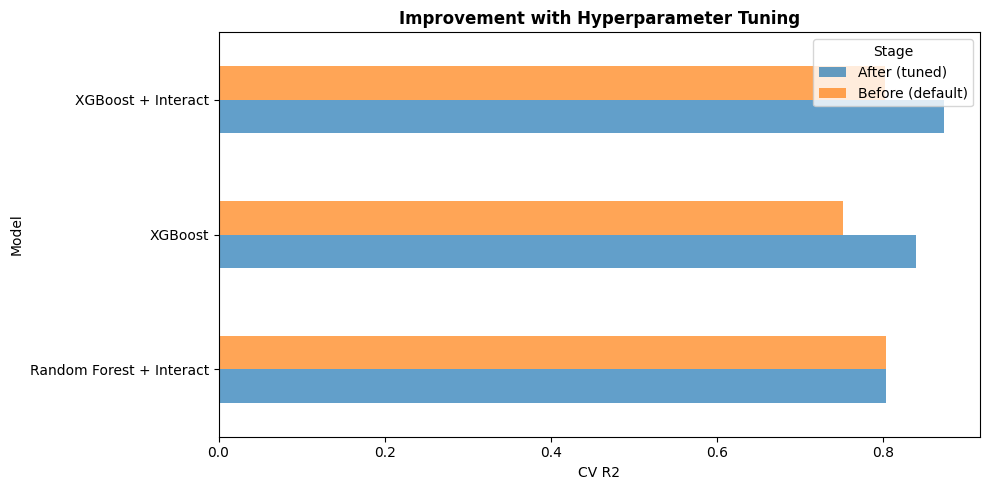

In [15]:
tuning_df = pd.DataFrame(tuning_results).sort_values('Test_R2', ascending=False)

print("\nRESULTS AFTER TUNING:\n")
print(tuning_df[['Model', 'Best_CV_R2', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Time_s']].to_string(index=False))

best_model_name = tuning_df.iloc[0]['Model']
print(f"\nBEST MODEL: {best_model_name}")
print(f"   Test R2: {tuning_df.iloc[0]['Test_R2']:.4f}")
print(f"   Test RMSE: {tuning_df.iloc[0]['Test_RMSE']:.4f}")
print(f"   Params: {tuning_df.iloc[0]['Best_Params']}")

fig, ax = plt.subplots(figsize=(10, 5))
before = results_df[results_df['Model'].isin(top3)][['Model', 'CV_R2_mean']].rename(columns={'CV_R2_mean': 'R2'})
before['Stage'] = 'Before (default)'
after = tuning_df[['Model', 'Best_CV_R2']].rename(columns={'Best_CV_R2': 'R2'})
after['Stage'] = 'After (tuned)'
compare = pd.concat([before, after])
compare_pivot = compare.pivot(index='Model', columns='Stage', values='R2')
compare_pivot.plot(kind='barh', ax=ax, alpha=0.7)
ax.set_xlabel('CV R2')
ax.set_title('Improvement with Hyperparameter Tuning', fontweight='bold')
plt.tight_layout()
plt.show()


## 10. Residual analysis of the best model


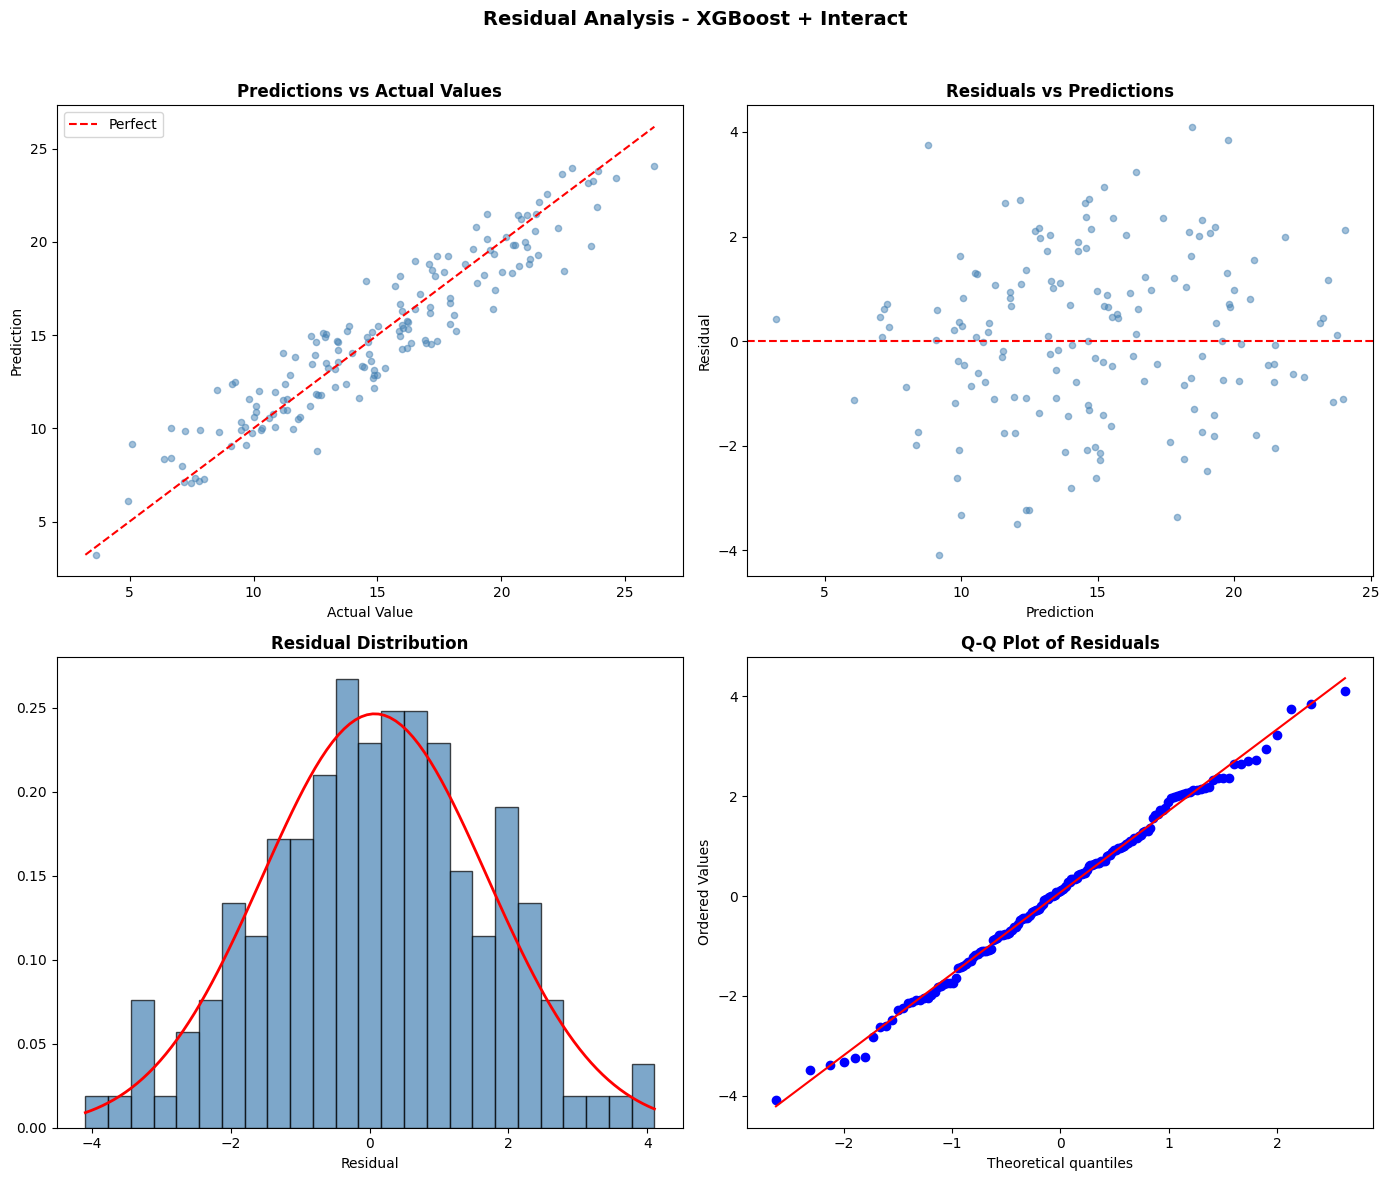

Residuals - Mean: 0.0751
Residuals - Std: 1.6184
Residuals - Skewness: -0.0690
Residuals - Kurtosis: -0.3019


In [16]:
best_config = model_configs[best_model_name]
if best_config['uses_interact']:
    X_te_best = X_test_int
else:
    X_te_best = X_test

best_model = tuned_models[best_model_name]
y_pred_best = best_model.predict(X_te_best)
residuals = y_test - y_pred_best

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].scatter(y_test, y_pred_best, alpha=0.5, s=20, c='steelblue')
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
axes[0, 0].set_xlabel('Actual Value')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].set_title('Predictions vs Actual Values', fontweight='bold')
axes[0, 0].legend()

axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5, s=20, c='steelblue')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Prediction')
axes[0, 1].set_ylabel('Residual')
axes[0, 1].set_title('Residuals vs Predictions', fontweight='bold')

axes[1, 0].hist(residuals, bins=25, edgecolor='black', alpha=0.7, color='steelblue', density=True)
x_range = np.linspace(residuals.min(), residuals.max(), 100)
axes[1, 0].plot(x_range, stats.norm.pdf(x_range, residuals.mean(), residuals.std()), 'r-', lw=2)
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_title('Residual Distribution', fontweight='bold')

stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals', fontweight='bold')

plt.suptitle(f'Residual Analysis - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"Residuals - Mean: {residuals.mean():.4f}")
print(f"Residuals - Std: {residuals.std():.4f}")
print(f"Residuals - Skewness: {stats.skew(residuals):.4f}")
print(f"Residuals - Kurtosis: {stats.kurtosis(residuals):.4f}")


## 11. Feature Importance of the best model


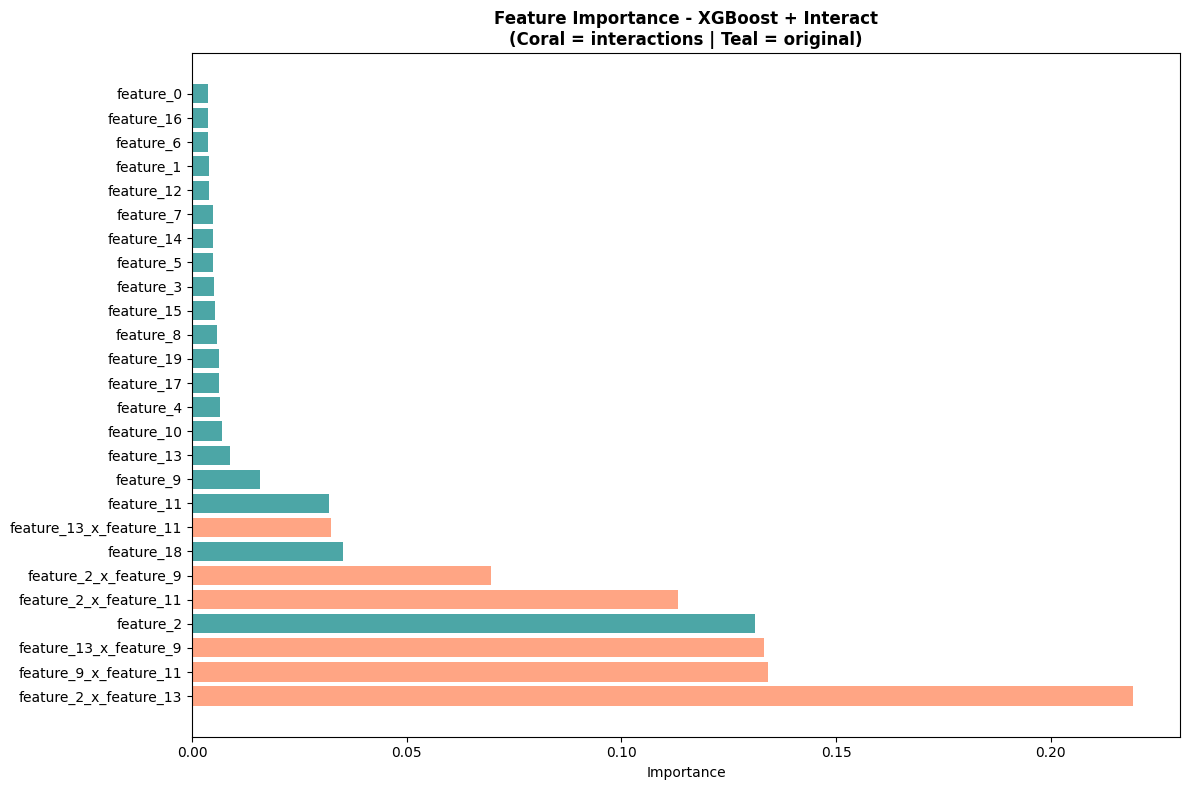


Top 10 features:
                Feature  Importance
 feature_2_x_feature_13    0.219118
 feature_9_x_feature_11    0.134083
 feature_13_x_feature_9    0.133193
              feature_2    0.131142
 feature_2_x_feature_11    0.113162
  feature_2_x_feature_9    0.069600
             feature_18    0.035131
feature_13_x_feature_11    0.032438
             feature_11    0.031913
              feature_9    0.015704


In [17]:
def plot_feature_importance(model, feature_names, model_name):
    """Extract and plot feature importance."""
    importances = None

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps'):
        inner = model.named_steps.get('model', None)
        if inner and hasattr(inner, 'coef_'):
            importances = np.abs(inner.coef_)
        elif inner and hasattr(inner, 'feature_importances_'):
            importances = inner.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)

    if importances is not None:
        imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        fig, ax = plt.subplots(figsize=(12, 8))
        colors = ['coral' if '_x_' in f else 'teal' for f in imp_df['Feature']]
        ax.barh(imp_df['Feature'], imp_df['Importance'], color=colors, alpha=0.7)
        ax.set_xlabel('Importance')
        ax.set_title(f'Feature Importance - {model_name}\n(Coral = interactions | Teal = original)', fontweight='bold')
        plt.tight_layout()
        plt.show()

        print("\nTop 10 features:")
        print(imp_df.head(10).to_string(index=False))
        return imp_df
    else:
        print(f"Cannot extract feature importance from {model_name}")
        return None

if best_config['uses_interact']:
    feat_names = list(X_interact.columns)
else:
    feat_names = features

imp_df = plot_feature_importance(best_model, feat_names, best_model_name)


## 12. Final retraining with ALL data (800 samples)

The winning model has been validated. Now we retrain it with all 800 samples
to maximize the information available before predicting the blind test.


In [18]:
if best_config['uses_interact']:
    X_full = X_interact.copy()
else:
    X_full = X.copy()

print(f"Model: {best_model_name}")
print(f"Uses interactions: {best_config['uses_interact']}")

final_model = best_model
final_model.fit(X_full, y)

cv_scores_final = cross_val_score(final_model, X_full, y, cv=cv, scoring='r2')
print(f"\nCV R2 (800 samples): {cv_scores_final.mean():.4f} +/- {cv_scores_final.std():.4f}")
final_model.fit(X_full, y)
print("\nFinal model trained with 800 samples")


Model: XGBoost + Interact
Uses interactions: True

CV R2 (800 samples): 0.8842 +/- 0.0127

Final model trained with 800 samples


## 13. Save model as .pkl


In [19]:
model_path = 'models/final_model.pkl'
joblib.dump(final_model, model_path)
print(f"Model saved to: {model_path}")

config_to_save = {
    'model_name': best_model_name,
    'uses_interactions': best_config['uses_interact'],
    'interaction_features': top_interact,
    'interaction_columns': interaction_cols,
    'feature_columns': features,
    'best_params': tuning_df.iloc[0]['Best_Params'],
    'cv_r2': cv_scores_final.mean(),
    'cv_r2_std': cv_scores_final.std()
}

joblib.dump(config_to_save, 'models/model_config.pkl')
print("Configuration saved to: models/model_config.pkl")

model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"\nModel size: {model_size:.2f} MB")
print(f"\nConfiguration:")
for k, v in config_to_save.items():
    print(f"  {k}: {v}")


Model saved to: models/final_model.pkl
Configuration saved to: models/model_config.pkl

Model size: 0.22 MB

Configuration:
  model_name: XGBoost + Interact
  uses_interactions: True
  interaction_features: ['feature_2', 'feature_13', 'feature_9', 'feature_11']
  interaction_columns: ['feature_2_x_feature_13', 'feature_2_x_feature_9', 'feature_2_x_feature_11', 'feature_13_x_feature_9', 'feature_13_x_feature_11', 'feature_9_x_feature_11']
  feature_columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19']
  best_params: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
  cv_r2: 0.8841820678427155
  cv_r2_std: 0.012697898202510525


## 14. MLflow - Experiment logging


In [20]:
if HAS_MLFLOW:
    mlflow.set_experiment("wizeline_ml_challenge")

    with mlflow.start_run(run_name=f"best_{best_model_name.replace(' ', '_').lower()}"):

        best_params = tuning_df.iloc[0]['Best_Params']
        if isinstance(best_params, dict):
            for param_name, param_value in best_params.items():
                mlflow.log_param(param_name, param_value)
        mlflow.log_param("model_type", best_model_name)
        mlflow.log_param("uses_interactions", best_config['uses_interact'])
        mlflow.log_param("n_features_original", len(features))
        mlflow.log_param("n_features_total", X_full.shape[1])
        mlflow.log_param("n_training_samples", len(y))
        mlflow.log_param("interaction_features", str(top_interact))

        mlflow.log_metric("cv_r2_mean", cv_scores_final.mean())
        mlflow.log_metric("cv_r2_std", cv_scores_final.std())
        mlflow.log_metric("test_r2", tuning_df.iloc[0]['Test_R2'])
        mlflow.log_metric("test_rmse", tuning_df.iloc[0]['Test_RMSE'])
        mlflow.log_metric("test_mae", tuning_df.iloc[0]['Test_MAE'])

        mlflow.sklearn.log_model(final_model, "model")
        mlflow.log_artifact('models/final_model.pkl')
        mlflow.log_artifact('models/model_config.pkl')

        run_id = mlflow.active_run().info.run_id
        print(f"Experiment registered in MLflow")
        print(f"   Run ID: {run_id}")
        print(f"\n   To view dashboard: mlflow ui")
        print(f"   Then open: http://localhost:5000")

    print("\n--- Registering all first-round models ---")
    for _, row in results_df.iterrows():
        with mlflow.start_run(run_name=row['Model'].replace(' ', '_').lower()):
            mlflow.log_param("model_type", row['Model'])
            mlflow.log_metric("cv_r2_mean", row['CV_R2_mean'])
            mlflow.log_metric("cv_r2_std", row['CV_R2_std'])
            mlflow.log_metric("cv_rmse_mean", row['CV_RMSE_mean'])
            mlflow.log_metric("test_r2", row['Test_R2'])
            mlflow.log_metric("test_rmse", row['Test_RMSE'])
            mlflow.log_metric("test_mae", row['Test_MAE'])
            mlflow.log_metric("time_s", row['Time_s'])
    print("All models registered")

else:
    print("MLflow not available. Install with: pip install mlflow")
    print("Results saved as .pkl in the models/ folder")


2026/02/26 03:17:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/26 03:17:16 INFO mlflow.store.db.utils: Updating database tables
2026/02/26 03:17:18 INFO mlflow.tracking.fluent: Experiment with name 'wizeline_ml_challenge' does not exist. Creating a new experiment.
2026/02/26 03:17:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 03:17:19 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Experiment registered in MLflow
   Run ID: 4518266cc2d54d4e97a3f80d0d1f0be4

   To view dashboard: mlflow ui
   Then open: http://localhost:5000

--- Registering all first-round models ---
All models registered


## 15. Blind Test Prediction


In [21]:
blind_test = pd.read_csv('blind_test_data.csv')
print(f"Blind test shape: {blind_test.shape}")

if best_config['uses_interact']:
    blind_test_processed, _ = add_interactions(blind_test, top_interact)
    print(f"With interactions: {blind_test_processed.shape}")
else:
    blind_test_processed = blind_test.copy()

blind_predictions = final_model.predict(blind_test_processed)

print(f"\nPredictions generated: {len(blind_predictions)}")
print(f"Range: [{blind_predictions.min():.4f}, {blind_predictions.max():.4f}]")
print(f"Mean: {blind_predictions.mean():.4f}")
print(f"Std: {blind_predictions.std():.4f}")

pred_df = pd.DataFrame({'target_pred': blind_predictions})
pred_df.to_csv('predictions/blind_test_predictions.csv', index=False)
print("\nPredictions saved to 'predictions/blind_test_predictions.csv'")
print(pred_df.head(10))


Blind test shape: (200, 20)
With interactions: (200, 26)

Predictions generated: 200
Range: [3.2953, 25.5090]
Mean: 14.3110
Std: 4.8628

Predictions saved to 'predictions/blind_test_predictions.csv'
   target_pred
0    13.493516
1    12.878013
2    15.321733
3    12.850356
4    15.867144
5    11.541366
6    19.683706
7    18.137077
8    11.079389
9     9.183522


## 16. Prediction distribution vs Training (with KDE smoothing)

Distribution comparison using Kernel Density Estimation to see
the smoothed curves of real target (training) vs predictions (blind test).


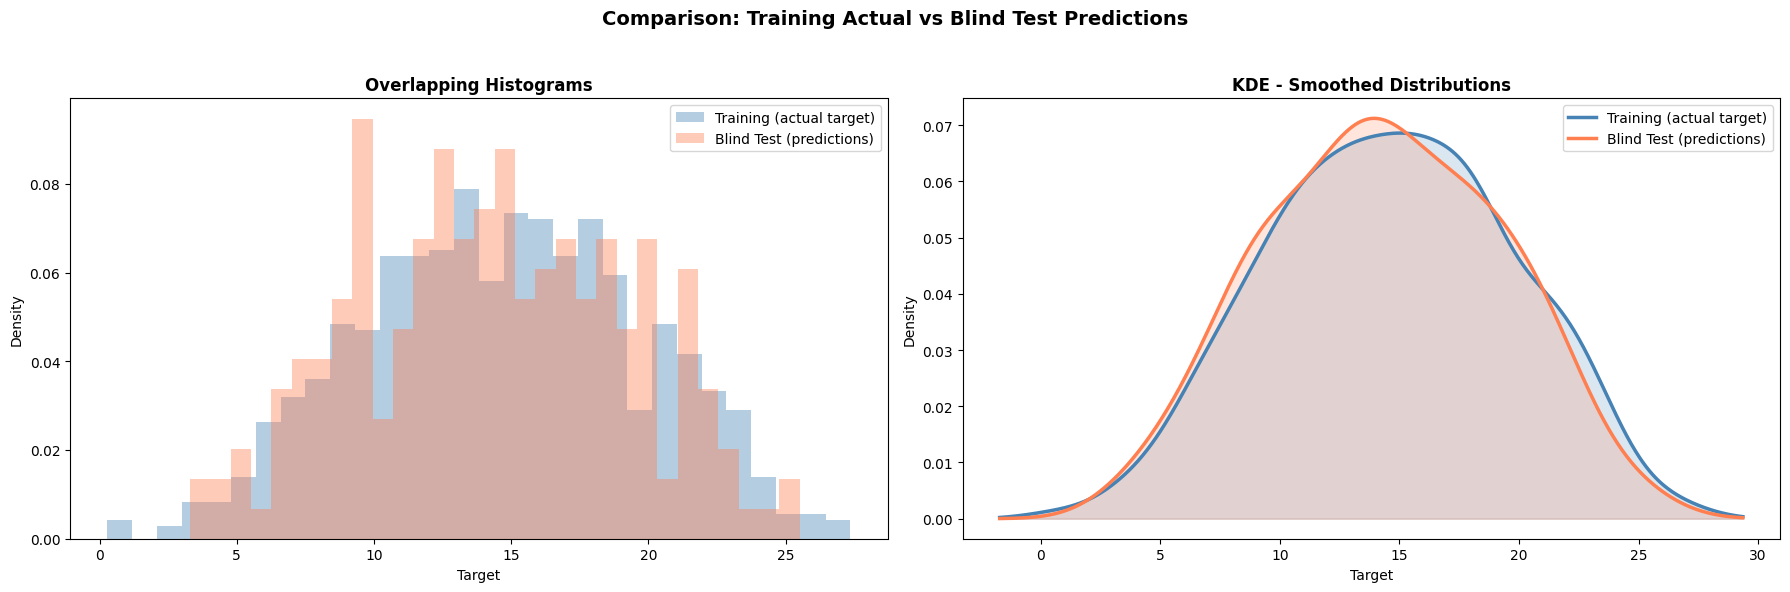

KS test: statistic=0.0500, p-value=0.8076
Distributions are similar (H0 not rejected)

Statistic           Training  Predictions
------------------------------------------
Mean                 14.6313      14.3110
Median               14.6880      14.3471
Std                   5.0895       4.8628
Min                   0.2798       3.2953
Max                  27.3608      25.5090


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Panel 1: Overlapping histograms
axes[0].hist(y, bins=30, alpha=0.4, label='Training (actual target)', color='steelblue', density=True)
axes[0].hist(blind_predictions, bins=30, alpha=0.4, label='Blind Test (predictions)', color='coral', density=True)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Density')
axes[0].set_title('Overlapping Histograms', fontweight='bold')
axes[0].legend()

# Panel 2: KDE smoothing
from scipy.stats import gaussian_kde

x_range = np.linspace(
    min(y.min(), blind_predictions.min()) - 2,
    max(y.max(), blind_predictions.max()) + 2,
    500
)

kde_train = gaussian_kde(y)
kde_pred = gaussian_kde(blind_predictions)

axes[1].plot(x_range, kde_train(x_range), color='steelblue', lw=2.5, label='Training (actual target)')
axes[1].fill_between(x_range, kde_train(x_range), alpha=0.2, color='steelblue')
axes[1].plot(x_range, kde_pred(x_range), color='coral', lw=2.5, label='Blind Test (predictions)')
axes[1].fill_between(x_range, kde_pred(x_range), alpha=0.2, color='coral')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Density')
axes[1].set_title('KDE - Smoothed Distributions', fontweight='bold')
axes[1].legend()

plt.suptitle('Comparison: Training Actual vs Blind Test Predictions', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

ks_stat, ks_p = stats.ks_2samp(y, blind_predictions)
print(f"KS test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")
if ks_p > 0.05:
    print("Distributions are similar (H0 not rejected)")
else:
    print("Distributions differ - review")

print(f"\n{'Statistic':<15} {'Training':>12} {'Predictions':>12}")
print("-" * 42)
print(f"{'Mean':<15} {y.mean():>12.4f} {blind_predictions.mean():>12.4f}")
print(f"{'Median':<15} {y.median():>12.4f} {np.median(blind_predictions):>12.4f}")
print(f"{'Std':<15} {y.std():>12.4f} {blind_predictions.std():>12.4f}")
print(f"{'Min':<15} {y.min():>12.4f} {blind_predictions.min():>12.4f}")
print(f"{'Max':<15} {y.max():>12.4f} {blind_predictions.max():>12.4f}")


## 17. Prediction from .pkl (production usage example)


In [23]:
loaded_model = joblib.load('models/final_model.pkl')
loaded_config = joblib.load('models/model_config.pkl')

print("Model loaded:")
print(f"   Type: {loaded_config['model_name']}")
print(f"   Uses interactions: {loaded_config['uses_interactions']}")
print(f"   CV R2: {loaded_config['cv_r2']:.4f}")

new_data = pd.read_csv('blind_test_data.csv')

if loaded_config['uses_interactions']:
    new_data_processed, _ = add_interactions(new_data, loaded_config['interaction_features'])
else:
    new_data_processed = new_data

predictions = loaded_model.predict(new_data_processed)
print(f"\n{len(predictions)} predictions generated from .pkl")
print(f"   Range: [{predictions.min():.4f}, {predictions.max():.4f}]")

assert np.allclose(predictions, blind_predictions), "ERROR: predictions do not match"
print("   Verification OK: predictions identical to original model output")


Model loaded:
   Type: XGBoost + Interact
   Uses interactions: True
   CV R2: 0.8842

200 predictions generated from .pkl
   Range: [3.2953, 25.5090]
   Verification OK: predictions identical to original model output


## Summary

### Selected model
Review step 9 for the winning model and its hyperparameters.

### Generated files
- `models/final_model.pkl` -- Trained model ready for prediction
- `models/model_config.pkl` -- Configuration (interactions, features, metrics)
- `predictions/blind_test_predictions.csv` -- 200 predictions with column `target_pred`
- `mlruns/` -- MLflow directory with all experiments
